# NITROGEN DIOXIDE (NO2)

In [5]:
%%capture
!pip install xarray==0.20.2  #latest package 2022.6.0 doesn't work
!pip install s3fs
!pip install netcdf4
!pip install h5netcdf

!pip install geopandas --quiet
!pip install shapely --quiet
!pip install contextily --quiet

In [6]:
import s3fs
import h5netcdf
import netCDF4
import xarray as xr

import pandas as pd
import numpy as np
import boto3
import matplotlib.pyplot as plt
import math

from shapely.geometry import Point, Polygon
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import contextily as cx

### LOOP THROUGH FOLDERS AND EXTRACT DATA

In [7]:
one_to_nine = ['01', '02', '03', '04', '05', '06', '07', '08', '09']
ten_to_32 = list(range(10, 32))
for i in ten_to_32:
    i = str(i)
ten_to_32_str = [str(i) for i in ten_to_32]
subfolder_list = one_to_nine + ten_to_32_str
print(subfolder_list)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']


In [8]:
#reduce down to only looking at half a month
limit = math.ceil((len(subfolder_list)/2))
subfolder_list = subfolder_list[0:limit]
print(subfolder_list)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16']


In [9]:
indices = [5, 6, 7, 8]   #take only keys at these indices from each subfolder, where we know london coverage appears
keys = []
for i in subfolder_list:
    bucket = 'meeo-s5p'
    subfolder = 'OFFL/L2__NO2___/2022/06/' + i + '/'   #loop through June's subfolders

    conn = boto3.client('s3')
    #some folders e.g. 10 don't exist, continue loop when error for these non existent folders
    try:
        contents = conn.list_objects(Bucket=bucket, Prefix=subfolder)['Contents']
    except:
        continue
    
    temp_list = []
    for f in contents:
        temp_list.append(f['Key'])
    
    for index in range(len(temp_list)):
        if index in indices:
            keys.append(temp_list[index])
            
keys[0:8]

['OFFL/L2__NO2___/2022/06/01/S5P_OFFL_L2__NO2____20220601T085512_20220601T103642_24005_02_020301_20220603T081149.nc',
 'OFFL/L2__NO2___/2022/06/01/S5P_OFFL_L2__NO2____20220601T103642_20220601T121812_24006_02_020301_20220603T081448.nc',
 'OFFL/L2__NO2___/2022/06/01/S5P_OFFL_L2__NO2____20220601T121812_20220601T135942_24007_02_020301_20220603T042457.nc',
 'OFFL/L2__NO2___/2022/06/01/S5P_OFFL_L2__NO2____20220601T135942_20220601T154112_24008_02_020301_20220603T055822.nc',
 'OFFL/L2__NO2___/2022/06/02/S5P_OFFL_L2__NO2____20220602T083611_20220602T101741_24019_02_020301_20220604T003417.nc',
 'OFFL/L2__NO2___/2022/06/02/S5P_OFFL_L2__NO2____20220602T101741_20220602T115911_24020_02_020301_20220604T023958.nc',
 'OFFL/L2__NO2___/2022/06/02/S5P_OFFL_L2__NO2____20220602T115911_20220602T134041_24021_02_020301_20220604T041253.nc',
 'OFFL/L2__NO2___/2022/06/02/S5P_OFFL_L2__NO2____20220602T134041_20220602T152211_24022_02_020301_20220604T053802.nc']

In [10]:
len(keys)

64

In [42]:
#find .nc file where filtering does not result in 0 longitude or latitudes (or co)

uk_keys = []
count = 0
uk_df = pd.DataFrame() 
for i in keys:
    #extract data from netcdf5 as xarray dataset
    fs = s3fs.S3FileSystem(anon=True)
    f = fs.open('s3://meeo-s5p/' + i)
    ds = xr.open_dataset(f, engine='h5netcdf', group = 'PRODUCT')

    #collapse 3 dimensions
    ds = ds.sel(time=ds.time[0])
    ds = ds.sel(layer=0)
    ds = ds.drop_dims('corner')
    ds = ds.drop_dims('polynomial_exponents')
    ds = ds.drop_dims('intensity_offset_polynomial_exponents')
    ds = ds.drop_dims('vertices')
    #only high quality data
    #ds = ds.where(ds.qa_value > 0.5, drop = True)
    #target parameter
    ds = ds[['nitrogendioxide_tropospheric_column', 'qa_value']]   #keep qa value too, can filter later if want
    #uk filter
    #ds = ds.where((ds.latitude > 50.10319) & (ds.latitude < 60.15456), drop = True)
    #ds = ds.where((ds.longitude > -7.64133) & (ds.longitude < 1.75159), drop = True)
    #london filter
    ds = ds.where((ds.latitude > 51.239405) & (ds.latitude < 51.737184), drop = True)
    ds = ds.where((ds.longitude > -0.625211) & (ds.longitude < 0.328289), drop = True)

    #drop nas along remaining dimensions - NO, for transparency of method, NAs will be dropped from dataframe than xarray
    #ds = ds.dropna('scanline', how='any')
    #ds = ds.dropna('ground_pixel', how='any')
    
    count += 1
    
    df = ds.to_dataframe()
    df = df.reset_index()
    df = df.drop(['scanline', 'ground_pixel'], axis = 1)
    df = df.dropna(how = 'any')
    
    if len(df) == 0:
        print(str(count) + '/' + str(len(keys)), '\t', '---> NONE FOUND')
        continue
    else:
        print(str(count) + '/' + str(len(keys)), '\t', '---> UK COVERAGE FOUND')
        #append to uk keys list
        uk_keys.append(i)
        #append to uk dataframe
        uk_df = uk_df.append(df)
        continue

1/64 	 ---> NONE FOUND
2/64 	 ---> UK COVERAGE FOUND
3/64 	 ---> UK COVERAGE FOUND
4/64 	 ---> NONE FOUND
5/64 	 ---> NONE FOUND
6/64 	 ---> NONE FOUND
7/64 	 ---> UK COVERAGE FOUND
8/64 	 ---> NONE FOUND
9/64 	 ---> NONE FOUND
10/64 	 ---> UK COVERAGE FOUND
11/64 	 ---> NONE FOUND
12/64 	 ---> NONE FOUND
13/64 	 ---> NONE FOUND
14/64 	 ---> UK COVERAGE FOUND
15/64 	 ---> UK COVERAGE FOUND
16/64 	 ---> NONE FOUND
17/64 	 ---> NONE FOUND
18/64 	 ---> UK COVERAGE FOUND
19/64 	 ---> UK COVERAGE FOUND
20/64 	 ---> NONE FOUND
21/64 	 ---> NONE FOUND
22/64 	 ---> UK COVERAGE FOUND
23/64 	 ---> UK COVERAGE FOUND
24/64 	 ---> NONE FOUND
25/64 	 ---> NONE FOUND
26/64 	 ---> UK COVERAGE FOUND
27/64 	 ---> UK COVERAGE FOUND
28/64 	 ---> NONE FOUND
29/64 	 ---> NONE FOUND
30/64 	 ---> UK COVERAGE FOUND
31/64 	 ---> NONE FOUND
32/64 	 ---> NONE FOUND
33/64 	 ---> NONE FOUND
34/64 	 ---> UK COVERAGE FOUND
35/64 	 ---> UK COVERAGE FOUND
36/64 	 ---> NONE FOUND
37/64 	 ---> NONE FOUND
38/64 	 ---> UK 

In [43]:
uk_df.head()

,nitrogendioxide_tropospheric_column,qa_value,time,layer,latitude,longitude
2746,0.000054,0.74,2022-06-01,0.0,51.259598,0.292720
2786,0.000112,0.74,2022-06-01,0.0,51.303303,0.252288
2825,0.000101,0.74,2022-06-01,0.0,51.271698,0.059670
2826,0.000149,0.74,2022-06-01,0.0,51.346848,0.211568
2865,0.000138,0.74,2022-06-01,0.0,51.315163,0.018826


In [44]:
len(uk_df)

2808

In [45]:
#persist dataframe to local csv file        
uk_df.to_csv('no2_sentinel_01-16june.csv', index = False)

### MANUAL EDA OF DATA FOR METRIC (e.g. setup filters needed)

In [11]:
fs = s3fs.S3FileSystem(anon=True)

# Open with s3fs
f = fs.open('s3://meeo-s5p/OFFL/L2__NO2___/2022/01/01/S5P_OFFL_L2__NO2____20220101T105540_20220101T123710_21864_02_020301_20220103T031616.nc')

# open xarray dataset
ds2 = xr.open_dataset(f, engine='h5netcdf', group = 'PRODUCT')   #or netcdf4

In [12]:
ds5 = ds2.copy()

In [13]:
ds5

<xarray.Dataset>
Dimensions:                                               (scanline: 4172, ground_pixel: 450, time: 1, corner: 4, polynomial_exponents: 6, intensity_offset_polynomial_exponents: 1, layer: 34, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column                   (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...

In [14]:
print(ds5.latitude.size)
print(ds5.longitude.size)

1877400
1877400


In [15]:
#filtering to 1 time essentially drops time dimension
ds5 = ds5.sel(time=ds5.time[0])

In [16]:
print(ds5.latitude.size)
print(ds5.longitude.size)

1877400
1877400


In [17]:
ds5 = ds5.sel(layer=0)

In [18]:
print(ds5.latitude.size)
print(ds5.longitude.size)

1877400
1877400


In [19]:
#only need scanline and ground_pixel dimensions for lon lat and co (see brackets)
ds5 = ds5.drop_dims('corner')
ds5 = ds5.drop_dims('polynomial_exponents')
ds5 = ds5.drop_dims('intensity_offset_polynomial_exponents')
ds5 = ds5.drop_dims('vertices')

In [20]:
print(ds5.latitude.size)
print(ds5.longitude.size)

1877400
1877400


In [21]:
ds5

<xarray.Dataset>
Dimensions:                                               (scanline: 4172, ground_pixel: 450)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
    time                                                  datetime64[ns] 2022...
    layer                                                 float64 0.0
    latitude                                              (scanline, ground_pixel) float32 ...
    longitude                                             (scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (scanline) datetime64[ns] ...
    time_utc                                              (scanline) object b...
    qa_value                                              (scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column                   (scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (scanline, ground_pixel) float32 ...
    averaging_kernel                                      (scanline, ground_pixel) float32 ...
    air_mass_factor_troposphere                           (scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (scanline, ground_pixel) float64 ...

In [22]:
#Recommend to ignore data with qa_value < 0.5 --> from data variable descriptor
#ds5 = ds5.where(ds5.qa_value > 0.5, drop = True)

In [23]:
print(ds5.latitude.size)
ds5.longitude.size

1877400


1877400

In [24]:
#filter by qa value then by co column so that dropping NAs (afterwards) only occurs for co column (retain as much as possible)
ds5 = ds5[['nitrogendioxide_tropospheric_column', 'qa_value']]

In [25]:
print(ds5.latitude.size)
ds5.longitude.size

1877400


1877400

In [26]:
#uk filter latitude, 500m is the lowest of the 50 layers
#ds5 = ds5.where((ds5.latitude > 50.10319) & (ds5.latitude < 60.15456), drop = True)
#ds5 = ds5.where((ds5.longitude > -7.64133) & (ds5.longitude < 1.75159), drop = True)

#london filter
ds5 = ds5.where((ds5.latitude > 51.239405) & (ds5.latitude < 51.737184), drop = True)
ds5 = ds5.where((ds5.longitude > -0.625211) & (ds5.longitude < 0.328289), drop = True)

In [27]:
print(ds5.latitude.size)
ds5.longitude.size

14196


14196

In [28]:
#BEST DROPPING NAS FROM DATAFRAME RATHER THAN XARRAY AS CLEARER WHATS BEING DONE

#drops NAs in this dimension
#will remove all NAs of co

#how ({"any", "all"}, default: "any") –
#any : if any NA values are present, drop that label
#all : if all values are NA, drop that label

#if any of longitude, latitude or co have null values, that data record becomes useless, so drop any

#ds5 = ds5.dropna('scanline', how='any')
#ds5 = ds5.dropna('ground_pixel', how='any')

In [29]:
ds5

<xarray.Dataset>
Dimensions:                              (scanline: 169, ground_pixel: 84)
Coordinates:
  * scanline                             (scanline) float64 3.541e+03 ... 3.7...
  * ground_pixel                         (ground_pixel) float64 48.0 ... 131.0
    time                                 datetime64[ns] 2022-01-01
    layer                                float64 0.0
    latitude                             (scanline, ground_pixel) float32 46....
    longitude                            (scanline, ground_pixel) float32 -0....
Data variables:
    nitrogendioxide_tropospheric_column  (scanline, ground_pixel) float32 nan...
    qa_value                             (scanline, ground_pixel) float32 nan...

In [30]:
df = ds5.to_dataframe()

In [31]:
df.head()

nitrogendioxide_tropospheric_column  qa_value  \
scanline ground_pixel                                                  
3541.0   48.0                                          NaN       NaN   
         49.0                                          NaN       NaN   
         50.0                                          NaN       NaN   
         51.0                                          NaN       NaN   
         52.0                                          NaN       NaN   

                            time  layer   latitude  longitude  
scanline ground_pixel                                          
3541.0   48.0         2022-01-01    0.0  46.939495  -0.596809  
         49.0         2022-01-01    0.0  46.983170  -0.494110  
         50.0         2022-01-01    0.0  47.026123  -0.392609  
         51.0         2022-01-01    0.0  47.068375  -0.292274  
         52.0         2022-01-01    0.0  47.109943  -0.193075

In [32]:
len(df)

14196

In [33]:
df = df.reset_index()

In [34]:
df.head()

,scanline,ground_pixel,nitrogendioxide_tropospheric_column,qa_value,time,layer,latitude,longitude
0,3541.0,48.0,NaN,NaN,2022-01-01,0.0,46.939495,-0.596809
1,3541.0,49.0,NaN,NaN,2022-01-01,0.0,46.983170,-0.494110
2,3541.0,50.0,NaN,NaN,2022-01-01,0.0,47.026123,-0.392609
3,3541.0,51.0,NaN,NaN,2022-01-01,0.0,47.068375,-0.292274
4,3541.0,52.0,NaN,NaN,2022-01-01,0.0,47.109943,-0.193075


In [35]:
df.columns

Index(['scanline', 'ground_pixel', 'nitrogendioxide_tropospheric_column',
       'qa_value', 'time', 'layer', 'latitude', 'longitude'],
      dtype='object')

In [36]:
df = df.drop(['scanline', 'ground_pixel'], axis = 1)
df.head()

,nitrogendioxide_tropospheric_column,qa_value,time,layer,latitude,longitude
0,NaN,NaN,2022-01-01,0.0,46.939495,-0.596809
1,NaN,NaN,2022-01-01,0.0,46.983170,-0.494110
2,NaN,NaN,2022-01-01,0.0,47.026123,-0.392609
3,NaN,NaN,2022-01-01,0.0,47.068375,-0.292274
4,NaN,NaN,2022-01-01,0.0,47.109943,-0.193075


In [37]:
print('Number of NAs:', df['nitrogendioxide_tropospheric_column'].isnull().sum())

Number of NAs: 14096


In [38]:
df = df.dropna(how = 'any')

In [39]:
df.head()

,nitrogendioxide_tropospheric_column,qa_value,time,layer,latitude,longitude
5745,0.000088,0.33,2022-01-01,0.0,51.245838,0.211708
5746,0.000061,1.00,2022-01-01,0.0,51.274513,0.290674
5828,0.000107,0.33,2022-01-01,0.0,51.263016,0.099561
5829,0.000026,0.45,2022-01-01,0.0,51.292065,0.179176
5830,0.000085,1.00,2022-01-01,0.0,51.320759,0.258201


In [40]:
len(df)

100

In [41]:
df.duplicated().value_counts()

False    100
dtype: int64

### MAPPING LATITUDES AND LONGITUDES

In [46]:
df = uk_df

In [47]:
lalo_data = df[['longitude', 'latitude']]
lalo_data.head()

,longitude,latitude
2746,0.292720,51.259598
2786,0.252288,51.303303
2825,0.059670,51.271698
2826,0.211568,51.346848
2865,0.018826,51.315163


In [48]:
london_map = gpd.read_file(r'London-wards-2018/London-wards-2018_ESRI/London_Ward_CityMerged.shp')

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(lalo_data, geometry = geometry, crs = 4326)
#4326 is the go to CRS for GPS lat lon, need to set here so conversion to another is standardised as setting wrong CRS here means conversion (to_crs) will be wrong

london_map['geometry'] = london_map['geometry'].to_crs(epsg=3857)
gdf['geometry'] = gdf['geometry'].to_crs(epsg=3857)

In [49]:
def makeLayeredMap(*args):
    """This function accepts an arbitrary number of geodataframes, plots them on top of a Contextily basemap. 
    NOTE: Please edit the Plotting-section to specify parameters for the number of layers and the formatting of each layer.
    Output: Saved file and layered map for display."""
    
    # Convert the CRS for all layers to EPSG3857 to match Contextily
    args = list(map(lambda x: x.to_crs(epsg=3857), args))
    # Create figure
    fig, ax = plt.subplots(1, figsize=(20, 20))
    #Set aspect to equal
    ax.set_aspect('equal')
    
    # PLOTTING: Specify layers to plot how to format each layer (colours, transparency, etc.):
    # Layer 1:
    args[0].boundary.plot(ax=ax, color='blue', edgecolor='k', alpha=0.3, zorder=1)
    # Layer 2:
    args[1].plot(ax=ax, color='red', markersize=400, marker='*', zorder=2)
    # ADD LAYERS here as needed:
    #args[2].plot(ax=ax, color='black', alpha=0.3, zorder=3)
    
    # Contextily basemap:
    cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
    
    # Turn off axis
    ax.axis('off')
    # Save as file
    fig.savefig('NO2_sentinel_london_satellite.png', dpi=300)
    layered_map = plt.show()
    return(layered_map)
    #plt.show()

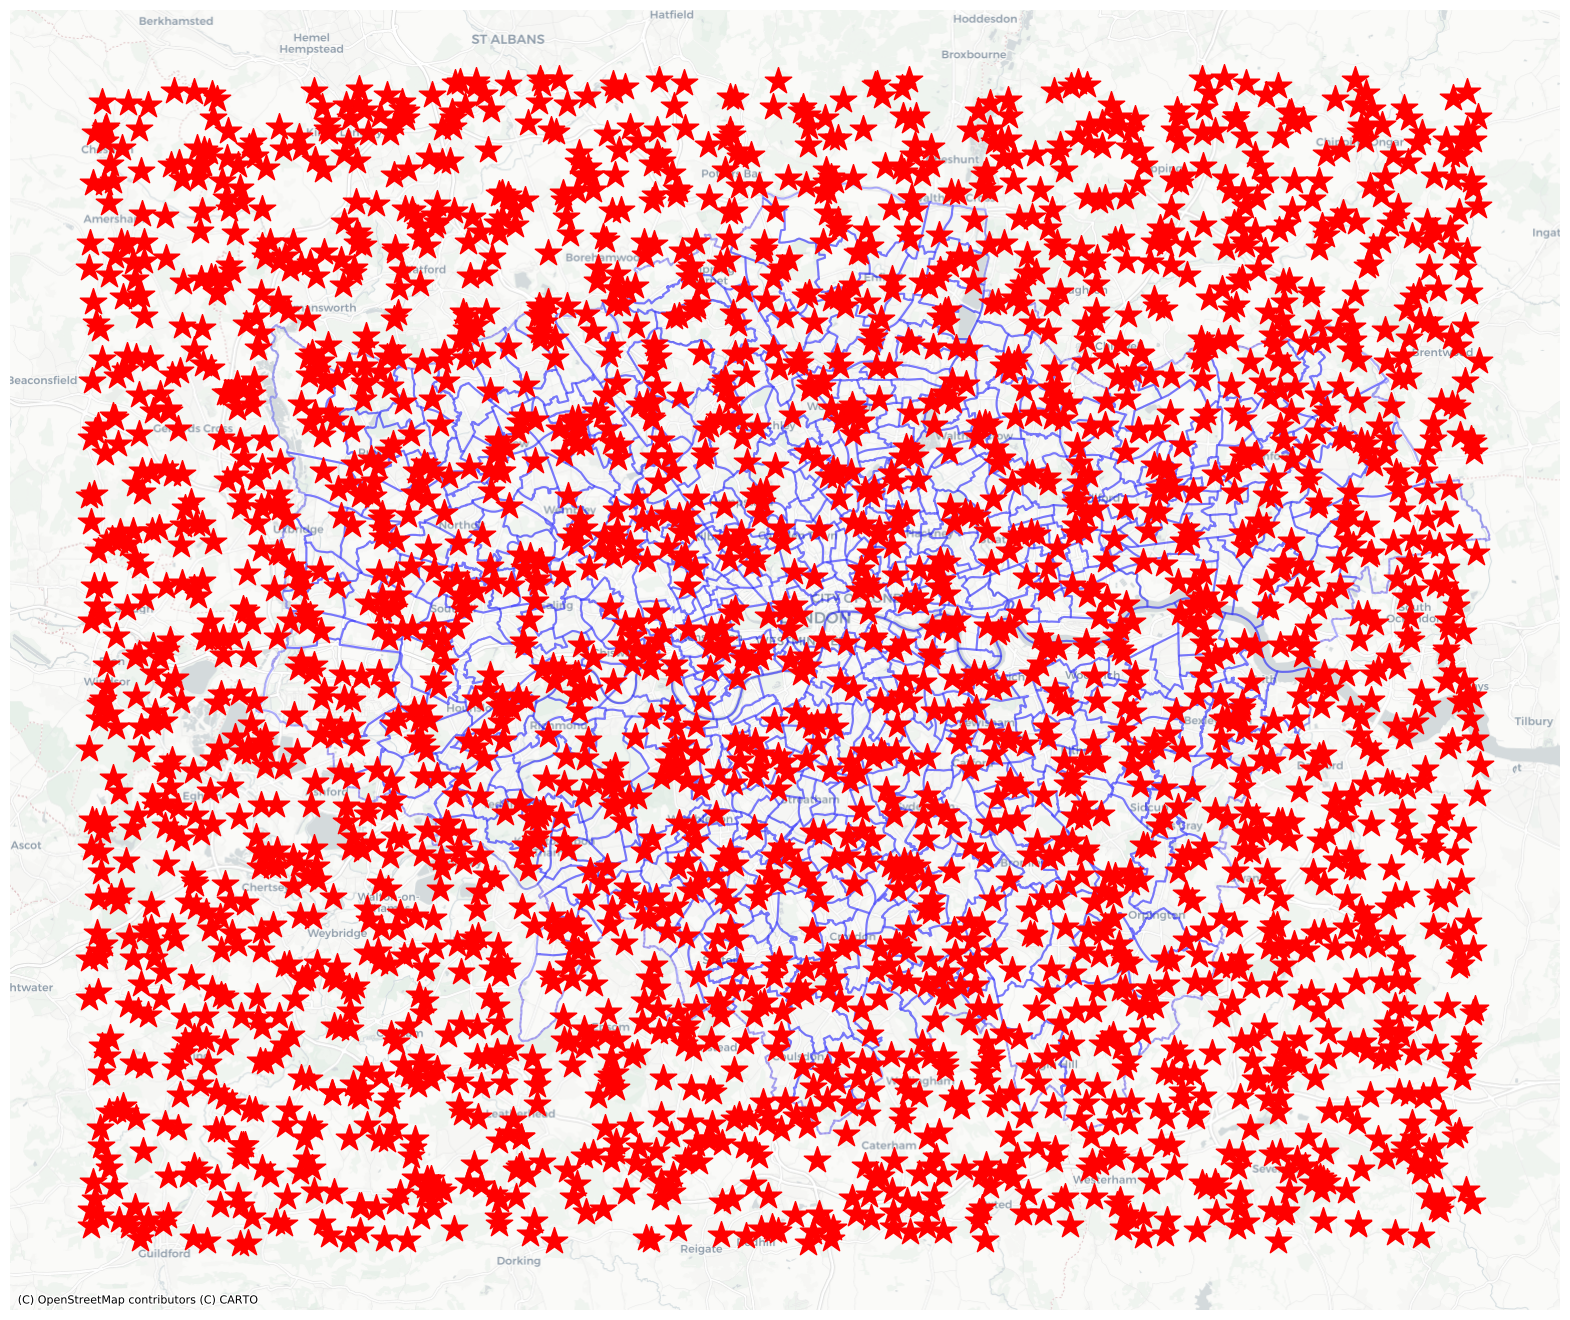

In [50]:
makeLayeredMap(london_map, gdf)